<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
source_folder = '/content/drive/MyDrive/TASI/Bayessian/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/Bayessian/ModelImbalance3'

In [16]:
%cd //content/drive/MyDrive/TASI/Bayessian/DataImbalance

/content/drive/MyDrive/TASI/Bayessian/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-w8r08unm
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-w8r08unm
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved h

In [17]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [18]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [21]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [22]:
# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [23]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [24]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [25]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=10,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []
    early_stopping_counter = 0

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print("Early stopping")
                    break

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [26]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6521, Valid Loss: 0.7228
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.6210, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.2738, Valid Loss: 0.2941
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.1369, Valid Loss: 0.2067
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/10], Train Loss: 0.0909, Valid Loss: 0.1357
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelI

Metrics loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt


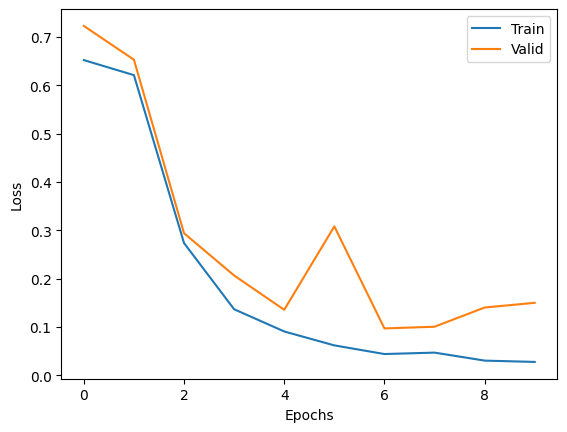

In [27]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Classification Report:
Real - Precision: 0.9633, Recall: 0.9292, F1-Score: 0.9459
Fake - Precision: 0.8632, Recall: 0.9266, F1-Score: 0.8938
Accuracy: 0.9283582089552239


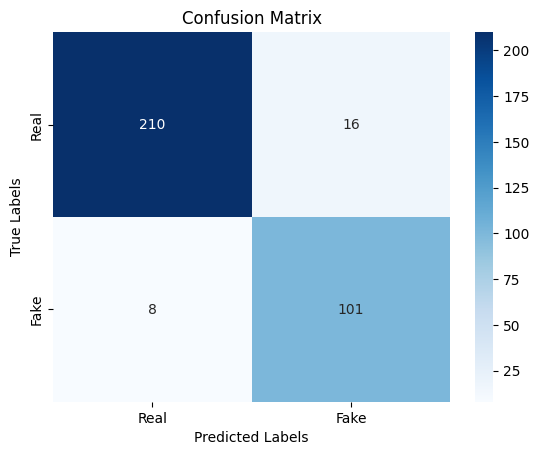

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning Random Search with Import Optuna

In [29]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [31]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                                  optimizer=optimizer,
                                                                                  criterion=criterion,
                                                                                  train_loader=train_iter,
                                                                                  valid_loader=valid_iter,
                                                                                  num_epochs=num_epochs,
                                                                                  eval_every=1,
                                                                                  file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    # Implement early stopping
    if len(valid_loss_list) >= 3:
        if best_valid_loss > results['best_valid_loss']:
            print("Validation loss hasn't improved in the last 3 epochs. Stopping early.")
            raise optuna.TrialPruned()

    return best_valid_loss

# Set up Optuna study with RandomSampler
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=36)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-20 12:55:06,602] A new study created in memory with name: no-name-d2c3966b-7f12-4258-89cb-a36a33759a1b
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6635, Valid Loss: 0.6275
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/9], Train Loss: 0.6493, Valid Loss: 0.6600
Epoch [3/9], Train Loss: 0.3422, Valid Loss: 0.2393
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/9], Train Loss: 0.2519, Valid Loss: 0.2249
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/9], Train Loss: 0.1368, Valid Loss: 0.2419
Epoch [6/9], Train Loss: 0.0878, Valid Loss: 0.2166
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/9], Tra

[I 2023-06-20 12:58:28,166] Trial 0 finished with value: 0.21662789919147535 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 0 with value: 0.21662789919147535.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6303, Valid Loss: 0.6188
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.3532, Valid Loss: 0.2698
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.2394, Valid Loss: 0.2208
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.1445, Valid Loss: 0.1415
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.0859, Valid Loss: 0.1296
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 13:01:25,039] Trial 1 finished with value: 0.12957737079289341 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 1 with value: 0.12957737079289341.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6075, Valid Loss: 0.3939
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/5], Train Loss: 0.2623, Valid Loss: 0.3001
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/5], Train Loss: 0.1647, Valid Loss: 0.3010
Epoch [4/5], Train Loss: 0.1287, Valid Loss: 0.4038
Epoch [5/5], Train Loss: 0.1300, Valid Loss: 0.2415


[I 2023-06-20 13:03:14,950] Trial 2 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6731, Valid Loss: 0.6500
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/7], Train Loss: 0.5612, Valid Loss: 0.6492
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/7], Train Loss: 0.2740, Valid Loss: 0.2656
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/7], Train Loss: 0.1765, Valid Loss: 0.2973
Epoch [5/7], Train Loss: 0.1282, Valid Loss: 0.3949
Epoch [6/7], Train Loss: 0.0746, Valid Loss: 0.2012
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt


[I 2023-06-20 13:05:46,792] Trial 3 pruned. 


Epoch [7/7], Train Loss: 0.0398, Valid Loss: 0.3657
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.5534, Valid Loss: 0.3662
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.2912, Valid Loss: 0.2430
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.1677, Valid Loss: 0.2443
Epoch [4/8], Train Loss: 0.0968, Valid Loss: 0.2002
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.0481, Valid Loss: 0.2686
Epoch [6/8], Train Loss: 0.0345, Valid Loss: 0.1818
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/8], Tra

[I 2023-06-20 13:08:45,477] Trial 4 finished with value: 0.12788819306297228 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 4 with value: 0.12788819306297228.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6604, Valid Loss: 0.6327
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/9], Train Loss: 0.5054, Valid Loss: 0.4449
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/9], Train Loss: 0.2830, Valid Loss: 0.2342
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/9], Train Loss: 0.1715, Valid Loss: 0.2126
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/9], Train Loss: 0.0932, Valid Loss: 0.1839
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 13:12:03,106] Trial 5 pruned. 


Epoch [9/9], Train Loss: 0.0307, Valid Loss: 0.3554
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6462, Valid Loss: 0.5631
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/5], Train Loss: 0.3833, Valid Loss: 0.3708
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/5], Train Loss: 0.2002, Valid Loss: 0.1963
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/5], Train Loss: 0.1356, Valid Loss: 0.2328


[I 2023-06-20 13:13:52,921] Trial 6 pruned. 


Epoch [5/5], Train Loss: 0.0728, Valid Loss: 0.2567
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6562, Valid Loss: 0.6472
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/5], Train Loss: 0.4704, Valid Loss: 0.9439
Epoch [3/5], Train Loss: 0.2119, Valid Loss: 0.5011
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/5], Train Loss: 0.1305, Valid Loss: 0.3831
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/5], Train Loss: 0.0813, Valid Loss: 0.1671


[I 2023-06-20 13:15:45,356] Trial 7 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6800, Valid Loss: 0.6454
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6677, Valid Loss: 0.6533
Epoch [3/8], Train Loss: 0.5810, Valid Loss: 0.3656
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.3226, Valid Loss: 0.2620
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.1928, Valid Loss: 0.1828
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [6/8], Train Loss: 0.0987, Valid Loss: 0.2168
Epoch [7/8], Tra

[I 2023-06-20 13:18:39,305] Trial 8 pruned. 


Epoch [8/8], Train Loss: 0.0256, Valid Loss: 0.2149
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6405, Valid Loss: 0.6272
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/7], Train Loss: 0.4117, Valid Loss: 0.4827
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/7], Train Loss: 0.2581, Valid Loss: 0.2345
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/7], Train Loss: 0.1730, Valid Loss: 0.2561
Epoch [5/7], Train Loss: 0.1186, Valid Loss: 0.3212


[I 2023-06-20 13:20:49,426] Trial 9 pruned. 


Epoch [6/7], Train Loss: 0.0721, Valid Loss: 0.4628
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6320, Valid Loss: 0.6227
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.3371, Valid Loss: 0.1990
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.1810, Valid Loss: 0.1798
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.0919, Valid Loss: 0.1597
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/10], Train Loss: 0.0386, Valid Loss: 0.2353
Epoch [6/10], Train Loss: 0.0192, Valid Loss: 0.2455


[I 2023-06-20 13:23:22,110] Trial 10 pruned. 


Epoch [7/10], Train Loss: 0.0613, Valid Loss: 0.2137
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6800, Valid Loss: 0.6585
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6879, Valid Loss: 0.6836
Epoch [3/8], Train Loss: 0.6772, Valid Loss: 0.6788


[I 2023-06-20 13:24:47,095] Trial 11 pruned. 


Epoch [4/8], Train Loss: 0.6600, Valid Loss: 0.6997
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6812, Valid Loss: 0.6935
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6744, Valid Loss: 0.6053
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.3583, Valid Loss: 0.3045
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.2035, Valid Loss: 0.2046
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.1084, Valid Loss: 0.2139
Epoch [6/8], Train Loss: 0.0644, Valid Loss: 0.1983
Model saved to =

[I 2023-06-20 13:27:52,195] Trial 12 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6881, Valid Loss: 0.6312
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/6], Train Loss: 0.5029, Valid Loss: 0.3693
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/6], Train Loss: 0.2986, Valid Loss: 0.2465
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/6], Train Loss: 0.1960, Valid Loss: 0.1630
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/6], Train Loss: 0.1161, Valid Loss: 0.2260


[I 2023-06-20 13:30:04,197] Trial 13 pruned. 


Epoch [6/6], Train Loss: 0.0567, Valid Loss: 0.2378
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6703, Valid Loss: 0.7012
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.7147, Valid Loss: 0.6659
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.6761, Valid Loss: 0.6346
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.7360, Valid Loss: 0.6592
Epoch [5/8], Train Loss: 0.7479, Valid Loss: 0.6566


[I 2023-06-20 13:32:18,121] Trial 14 pruned. 


Epoch [6/8], Train Loss: 0.7221, Valid Loss: 0.6554
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6557, Valid Loss: 0.6805
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6908, Valid Loss: 0.6843
Epoch [3/8], Train Loss: 0.4929, Valid Loss: 0.7333
Epoch [4/8], Train Loss: 0.2466, Valid Loss: 0.4429
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.1556, Valid Loss: 0.3932
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [6/8], Train Loss: 0.0841, Valid Loss: 0.3406
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/8], Tra

[I 2023-06-20 13:35:15,040] Trial 15 pruned. 


Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6908, Valid Loss: 0.6765
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.6219, Valid Loss: 0.3895
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.2618, Valid Loss: 0.1815
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.1911, Valid Loss: 0.1560
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/10], Train Loss: 0.0913, Valid Loss: 0.1885
Epoch [6/10], Train Loss: 0.0487, Valid Loss: 0.1238
Model save

[I 2023-06-20 13:38:37,161] Trial 16 finished with value: 0.1238212793333722 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 16 with value: 0.1238212793333722.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6665, Valid Loss: 0.6393
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.6507, Valid Loss: 0.4057
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.3916, Valid Loss: 0.3411
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.2134, Valid Loss: 0.2779
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/10], Train Loss: 0.1385, Valid Loss: 0.2642
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelI

[I 2023-06-20 13:42:00,614] Trial 17 pruned. 


Epoch [9/10], Train Loss: 0.0466, Valid Loss: 0.2442
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6719, Valid Loss: 0.6444
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.5040, Valid Loss: 0.3557
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.2384, Valid Loss: 0.1783
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.1706, Valid Loss: 0.2346
Epoch [5/10], Train Loss: 0.1003, Valid Loss: 0.2046
Epoch [6/10], Train Loss: 0.0426, Valid Loss: 0.1627
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/1

[I 2023-06-20 13:45:15,671] Trial 18 pruned. 


Epoch [9/10], Train Loss: 0.0104, Valid Loss: 0.2648
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6390, Valid Loss: 0.4545
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/6], Train Loss: 0.3491, Valid Loss: 0.3379
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/6], Train Loss: 0.2384, Valid Loss: 0.2157
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/6], Train Loss: 0.1202, Valid Loss: 0.1437
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/6], Train Loss: 0.0950, Valid Loss: 0.2305


[I 2023-06-20 13:47:30,294] Trial 19 pruned. 


Epoch [6/6], Train Loss: 0.0773, Valid Loss: 0.3102
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6920, Valid Loss: 0.6662
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.7111, Valid Loss: 0.6572
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.6444, Valid Loss: 0.5646
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.3159, Valid Loss: 0.3133
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/10], Train Loss: 0.1834, Valid Loss: 0.1802
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelI

[I 2023-06-20 13:50:36,069] Trial 20 pruned. 


Epoch [8/10], Train Loss: 0.0275, Valid Loss: 0.4299
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.7005, Valid Loss: 0.6559
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.5736, Valid Loss: 0.4691
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.3338, Valid Loss: 0.2872
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.1802, Valid Loss: 0.2627
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.1092, Valid Loss: 0.1806
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 13:53:37,501] Trial 21 pruned. 


Epoch [8/8], Train Loss: 0.0359, Valid Loss: 0.2414
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6916, Valid Loss: 0.6588
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6955, Valid Loss: 0.6567
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.5760, Valid Loss: 0.3501
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.2755, Valid Loss: 0.2219
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.2008, Valid Loss: 0.2120
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 13:56:36,395] Trial 22 pruned. 


Epoch [8/8], Train Loss: 0.0628, Valid Loss: 0.1932
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6743, Valid Loss: 0.6915
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.6881, Valid Loss: 0.6184
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.6633, Valid Loss: 0.6930
Epoch [4/10], Train Loss: 0.6835, Valid Loss: 0.6551


[I 2023-06-20 13:58:24,469] Trial 23 pruned. 


Epoch [5/10], Train Loss: 0.7244, Valid Loss: 0.6622
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6663, Valid Loss: 0.6653
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.5445, Valid Loss: 0.3462
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.2466, Valid Loss: 0.1780
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.1942, Valid Loss: 0.1619
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.0782, Valid Loss: 0.1461
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 14:01:25,464] Trial 24 finished with value: 0.08509231308874275 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 24 with value: 0.08509231308874275.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6552, Valid Loss: 0.6394
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/9], Train Loss: 0.4981, Valid Loss: 0.4462
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/9], Train Loss: 0.2195, Valid Loss: 0.3074
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/9], Train Loss: 0.1712, Valid Loss: 0.5154
Epoch [5/9], Train Loss: 0.0888, Valid Loss: 0.4175
Epoch [6/9], Train Loss: 0.0618, Valid Loss: 0.1711
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/9], Tra

[I 2023-06-20 14:04:40,195] Trial 25 pruned. 


Epoch [9/9], Train Loss: 0.0023, Valid Loss: 0.2095
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6908, Valid Loss: 0.6710
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/6], Train Loss: 0.6924, Valid Loss: 0.6922
Epoch [3/6], Train Loss: 0.6840, Valid Loss: 0.6823


[I 2023-06-20 14:06:05,171] Trial 26 pruned. 


Epoch [4/6], Train Loss: 0.6831, Valid Loss: 0.6976
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6657, Valid Loss: 0.6121
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/7], Train Loss: 0.4015, Valid Loss: 0.2580
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/7], Train Loss: 0.2025, Valid Loss: 0.1748
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/7], Train Loss: 0.0954, Valid Loss: 0.1733
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/7], Train Loss: 0.0360, Valid Loss: 0.2553
Epoch [6/7], Train Loss: 0.0238, Valid Loss: 0.2025


[I 2023-06-20 14:08:38,087] Trial 27 pruned. 


Epoch [7/7], Train Loss: 0.0269, Valid Loss: 0.3196
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6185, Valid Loss: 0.6577
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/10], Train Loss: 0.2631, Valid Loss: 0.2875
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/10], Train Loss: 0.1884, Valid Loss: 0.1782
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/10], Train Loss: 0.1204, Valid Loss: 0.2488
Epoch [5/10], Train Loss: 0.0543, Valid Loss: 0.2902


[I 2023-06-20 14:10:47,559] Trial 28 pruned. 


Epoch [6/10], Train Loss: 0.0184, Valid Loss: 0.3293
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6289, Valid Loss: 0.5427
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/9], Train Loss: 0.3219, Valid Loss: 0.2930
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/9], Train Loss: 0.1767, Valid Loss: 0.2678
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/9], Train Loss: 0.1054, Valid Loss: 0.2689
Epoch [5/9], Train Loss: 0.0971, Valid Loss: 0.3042
Epoch [6/9], Train Loss: 0.0389, Valid Loss: 0.1617
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/9], Tra

[I 2023-06-20 14:14:05,518] Trial 29 pruned. 


Epoch [9/9], Train Loss: 0.0020, Valid Loss: 0.2885
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6477, Valid Loss: 0.6684
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6815, Valid Loss: 0.7024
Epoch [3/8], Train Loss: 0.7047, Valid Loss: 0.6743


[I 2023-06-20 14:15:31,618] Trial 30 pruned. 


Epoch [4/8], Train Loss: 0.6923, Valid Loss: 0.6824
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6810, Valid Loss: 0.7046
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.5975, Valid Loss: 0.4283
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.2530, Valid Loss: 0.2450
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.1606, Valid Loss: 0.3440
Epoch [5/8], Train Loss: 0.0779, Valid Loss: 0.2593
Epoch [6/8], Train Loss: 0.0413, Valid Loss: 0.1888
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [7/8], Tra

[I 2023-06-20 14:18:26,605] Trial 31 pruned. 


Epoch [8/8], Train Loss: 0.0309, Valid Loss: 0.3347
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6811, Valid Loss: 0.6720
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.6033, Valid Loss: 0.4205
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.2946, Valid Loss: 0.2207
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.2020, Valid Loss: 0.2966
Epoch [5/8], Train Loss: 0.1181, Valid Loss: 0.1889
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [6/8], Train Loss: 0.0621, Valid Loss: 0.1701
Model saved to =

[I 2023-06-20 14:21:21,097] Trial 32 pruned. 


Epoch [8/8], Train Loss: 0.0185, Valid Loss: 0.3224
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6698, Valid Loss: 0.7107
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.5581, Valid Loss: 0.4050
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.3513, Valid Loss: 0.2683
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.2007, Valid Loss: 0.2458
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [5/8], Train Loss: 0.1122, Valid Loss: 0.1772
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbala

[I 2023-06-20 14:24:21,133] Trial 33 pruned. 


Epoch [8/8], Train Loss: 0.0146, Valid Loss: 0.1284
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6495, Valid Loss: 0.6721
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/5], Train Loss: 0.6590, Valid Loss: 0.5085
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/5], Train Loss: 0.3186, Valid Loss: 0.2484
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/5], Train Loss: 0.1539, Valid Loss: 0.2611


[I 2023-06-20 14:26:11,262] Trial 34 pruned. 


Epoch [5/5], Train Loss: 0.0811, Valid Loss: 0.3343
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6317, Valid Loss: 0.5073
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [2/8], Train Loss: 0.3451, Valid Loss: 0.2490
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [3/8], Train Loss: 0.2152, Valid Loss: 0.1615
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [4/8], Train Loss: 0.1336, Valid Loss: 0.1878
Epoch [5/8], Train Loss: 0.0898, Valid Loss: 0.1348
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Epoch [6/8], Train Loss: 0.0541, Valid Loss: 0.2278
Epoch [7/8], Tra

[I 2023-06-20 14:29:08,201] Trial 35 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.
Best model: lr=2e-05, num_epochs=8, batch_size=16
Best valid loss: 0.12666060339792498


Metrics loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/metrics.pt


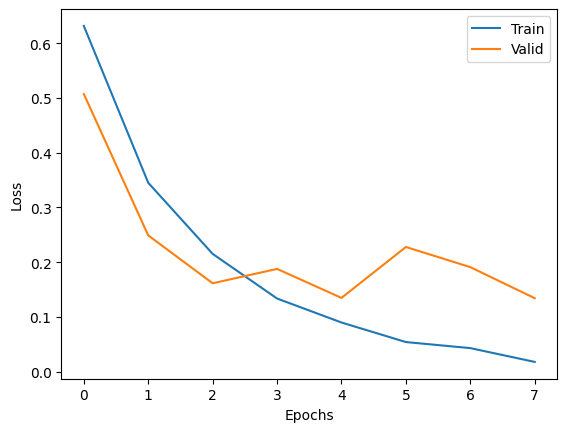

In [32]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance3/model.pt
Classification Report:
Real - Precision: 0.9726, Recall: 0.9425, F1-Score: 0.9573
Fake - Precision: 0.8879, Recall: 0.9450, F1-Score: 0.9156
Accuracy: 0.9432835820895522


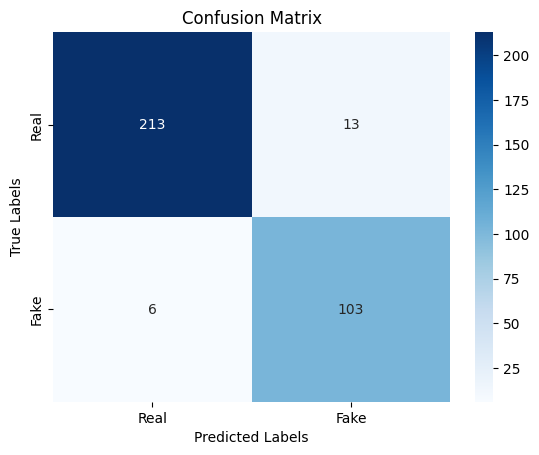

In [33]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)